### End to end train both networks

In [1]:
from keras.layers import Input, Dense, Activation, Lambda, Dropout, Concatenate, Reshape
from keras.models import Model, Sequential
from keras.callbacks import TensorBoard, Callback
from keras import optimizers
from keras import backend as K

import tensorflow as tf

from keras.regularizers import l2


/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
### Hyperparameters

experiment_id = 0

learning_rate = 0.0001

epochs = [200, 20000, 10000, 4000]
batch_sizes = [1024, 1024, 128, 1024]

lambda_1 = 0.1       
lambda_2 = 0.005     

#################

epoch = epochs[experiment_id]
batch_size = batch_sizes[experiment_id]

### Define compresion network

In [3]:
input_data = Input(batch_shape=(batch_size,120), name='input_placeholder')

encoded = Dense(60, activation='tanh', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(input_data)
encoded = Dense(30, activation='tanh', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(encoded)
encoded = Dense(10, activation='tanh', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(encoded)

low_dim = Dense(1, activation='linear', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001), name='lowdim')(encoded)

decoded = Dense(10, activation='tanh', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(low_dim)
decoded = Dense(30, activation='tanh', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(decoded)
decoded = Dense(60, activation='tanh', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(decoded)
decoded = Dense(120, activation='linear', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001), name='reconstructed')(decoded)



- Define similarity metrics

In [4]:
def cos_sim(a_b):
    '''
    a: batch x 120
    b: batch x 120 
    
    output: batch x 1
    '''
    a, b = a_b
    
    norm_a = K.sqrt(K.sum(a ** 2, axis=-1))
    norm_b = K.sqrt(K.sum(b ** 2, axis=-1))
    
    out = K.sum(a * b, axis=-1) / (norm_a * norm_b)
    out = K.reshape(out, [batch_size, 1])
    
    return out

def relative_euc_dist(a_b):
    '''
    a: batch x 120
    b: batch x 120 
    
    output: batch x 1
    '''
    a,b = a_b
    
    norm_diff = K.sqrt(K.sum((a - b)**2, axis=-1))
    norm_a = K.sqrt(K.sum(a ** 2, axis=-1))
    
    out = norm_diff / norm_a
    out = K.reshape(out, [batch_size, 1])

    return out

In [5]:
layer_cossim = Lambda(cos_sim,
                      name='cos_sim')([input_data, decoded])

In [6]:
layer_cossim

<tf.Tensor 'cos_sim/Reshape:0' shape=(1024, 1) dtype=float32>

In [7]:
layer_relativeEuc = Lambda(relative_euc_dist, 
                           name='relative_euc_dist')([input_data, decoded])

In [8]:
layer_relativeEuc

<tf.Tensor 'relative_euc_dist/Reshape:0' shape=(1024, 1) dtype=float32>

- No need to reshape low_dim

In [9]:
low_dim

<tf.Tensor 'lowdim/BiasAdd:0' shape=(1024, 1) dtype=float32>

- Obtain "z"

In [10]:
def funct_concat(tensors):
    return K.concatenate(tensors)

layer_concat = Lambda(funct_concat, name="z")([low_dim, layer_cossim, layer_relativeEuc])

In [11]:
layer_concat

<tf.Tensor 'z/concat:0' shape=(1024, 3) dtype=float32>

### Define estimation network

In [12]:
input_est = layer_concat #Input(shape=(3,))(layer_concat)

est_layer = Dense(10, activation='tanh', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(input_est)   ####(input_est)
est_layer = Dropout(0.5)(est_layer)
est_output = Dense(4, activation='softmax', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001), name='output_placeholder')(est_layer)


### Build full network

In [13]:
full_network = Model(input=input_data, outputs=est_output)

/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("ou..., inputs=Tensor("in...)`
  """Entry point for launching an IPython kernel.


In [14]:
full_network.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_placeholder (InputLayer)  (1024, 120)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (1024, 60)           7260        input_placeholder[0][0]          
__________________________________________________________________________________________________
dense_2 (Dense)                 (1024, 30)           1830        dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (1024, 10)           310         dense_2[0][0]                    
__________________________________________________________________________________________________
lowdim (De

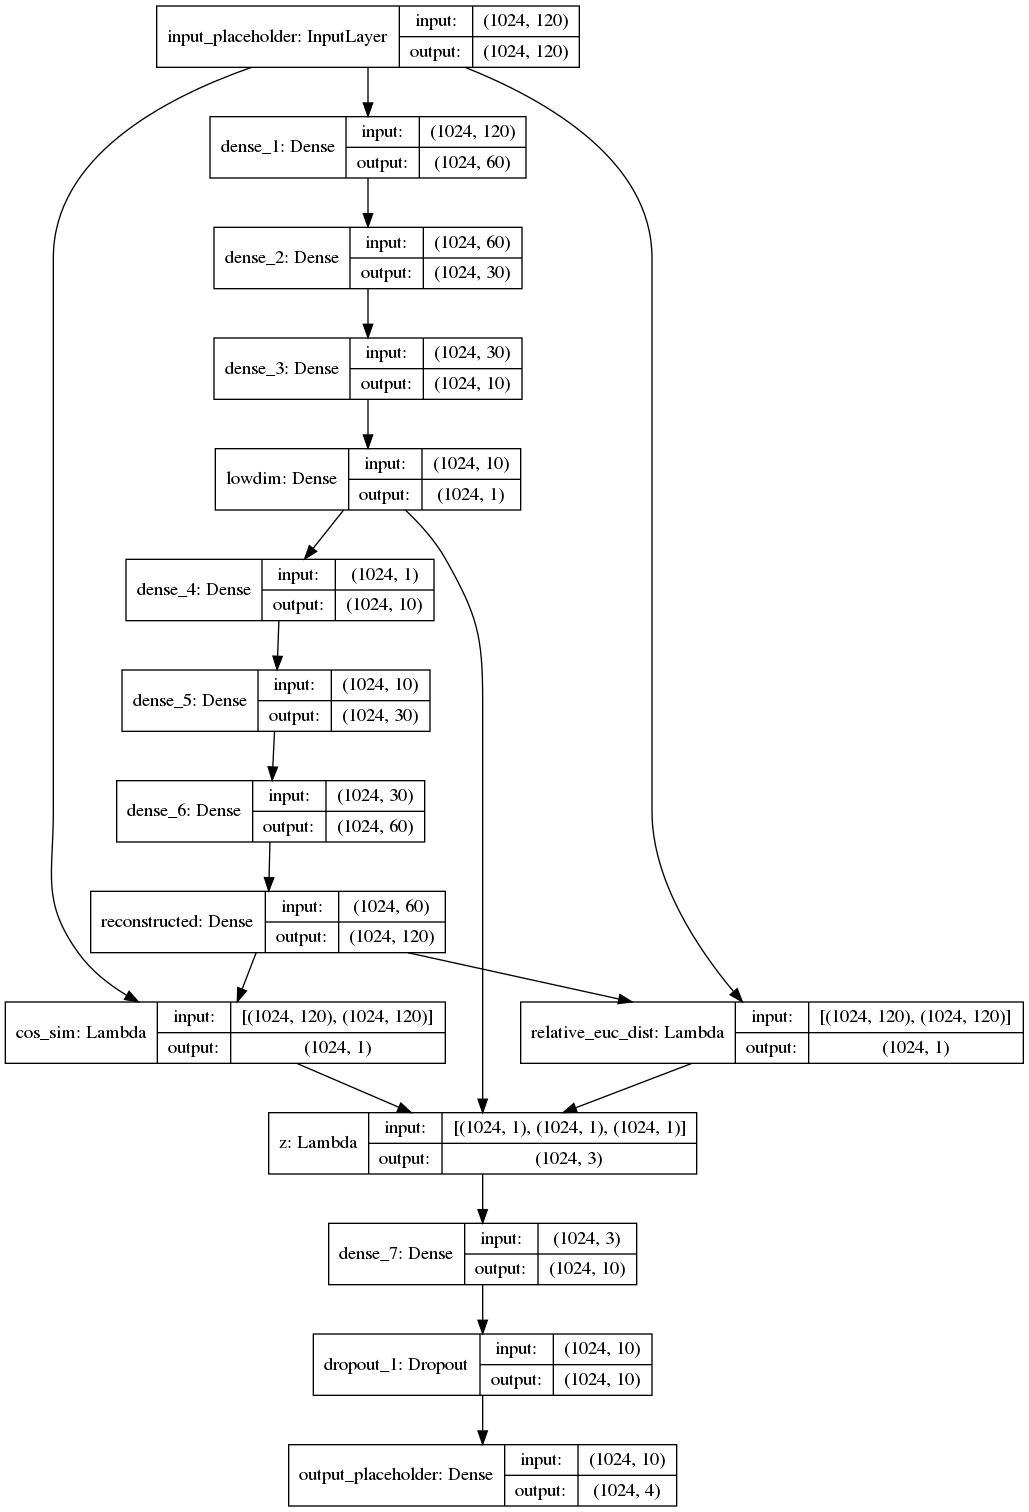

In [15]:
### model visualization
from keras.utils import plot_model


model = full_network

plot_model(model, to_file='model.png', show_layer_names=True, show_shapes=True)

from IPython.display import Image
Image(filename='model.png') 

### Load already saved dataset

In [16]:
import numpy as np

In [17]:
with np.load('kdd99_train_test.npz') as data:
    x_train = data['x_train']     
    x_test = data['x_test']
    x_all = np.concatenate([x_train, x_test], axis=0)

In [18]:
x_all.shape

(494021, 120)

- Get only the normal data

In [19]:
normal_data = x_all[np.where(x_all[:,-1] == 1)]   ##last column is the normal column

In [20]:
from sklearn.model_selection import train_test_split

x_train, x_test = train_test_split(normal_data, test_size=0.5, random_state=42)

In [21]:
x_train.shape

(48639, 120)

In [22]:
x_test.shape

(48639, 120)

- Assign arbitrary output (assuming first column is normal)

In [23]:
y_train = np.zeros((len(x_train),4))

y_train[:,0] = 1

In [24]:
y_train.shape

(48639, 4)

### GMM parameters

- k: number of clusters (4 for here)
- N: batch size
- d: Dimension of latent vector z (3 here)

- gamma ($\gamma$) : membership predictions (softmax output of estimation net) [$N \times K$]
- phi ($\phi$): gaussian probabilities [$K$]
- mu ($\mu$): gaussian means [$K \times d$]
- sigma ($\Sigma$): gaussian covariances [$K \times d \times d$]

In [25]:
k = 4 
N = batch_size 
d = 3

- GMM parameters

In [26]:
phi = np.zeros((k))
mu = np.zeros((k,d))
sigma = np.zeros((k,d,d))

In [27]:
sigma[:] = np.eye(d)

In [28]:
def printGmmParams():
    print("---shapes---")
    print("phi:\n",phi.shape)
    print("mu:\n",mu.shape)
    print("sigma:\n",sigma.shape)
    
    print("")
    
    print("---values---")
    print("phi:\n",phi)
    print("mu:\n",mu)
    print("sigma:\n",sigma)

In [29]:
printGmmParams()

---shapes---
phi:
 (4,)
mu:
 (4, 3)
sigma:
 (4, 3, 3)

---values---
phi:
 [0. 0. 0. 0.]
mu:
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
sigma:
 [[[1. 0. 0.]
  [0. 1. 0.]
  [0. 0. 1.]]

 [[1. 0. 0.]
  [0. 1. 0.]
  [0. 0. 1.]]

 [[1. 0. 0.]
  [0. 1. 0.]
  [0. 0. 1.]]

 [[1. 0. 0.]
  [0. 1. 0.]
  [0. 0. 1.]]]


### Total loss calculation

In [30]:
isVerbose = True

In [31]:
### (for the first time run of the totalLoss function)

choices = np.random.choice(len(x_train), size=batch_size, replace=False)

batch_x_train = x_train[choices]
batch_y_train = y_train[choices]

batch_train = (batch_x_train, batch_y_train)

- Define energy function

In [32]:
def computeEnergy(z_i):
    """
    compute E(z_i) in loss function
    """
    
    log_sum = 0
    for cluster in range(k):
        diff = z_i - mu[cluster]
        diff_t = diff.reshape(-1,1)   

        sigma_inv = sigma_inv = np.linalg.inv(sigma[cluster])
        
        exp_term = np.exp(-0.5 * np.matmul(np.matmul(diff, sigma_inv), diff_t))
        denom = denom = np.sqrt(np.linalg.det(2 * np.pi * sigma[cluster]))

        log_sum += phi[cluster] * (exp_term / denom)
        
                
    global isVerbose
    if isVerbose:
        print("diff:\n",diff)
        print("diff_t:\n",diff_t)
        print("sigma_inv:\n",sigma_inv)
        print("exp_term:\n", exp_term)
        print("denom:\n", denom)
        
        isVerbose = False

    return -np.log(log_sum + 1e-6)

- Define total loss

In [33]:
def totalLoss(yTrue, yPred):
    ### autoencoder loss
    autoenc_loss = K.sqrt((input_data - decoded)**2)
    autoenc_loss /= batch_size
    
    
    ### obtain z for current batch
    global batch_train
    z = K.function([input_data], [layer_concat])([batch_train[0]])[0]
    
    
    ### sample energy
    sample_en = 0
    for z_i in z:
        sample_en += computeEnergy(z_i)
    sample_en *= lambda_1
    sample_en /= batch_size    
    
    ### diagonal regularization
    global sigma
    
    p = 0
    for cluster in range(k):
        for dim in range(d):
            p += (1 / sigma[cluster, dim, dim])
    p += lambda_2

    total_loss = autoenc_loss + sample_en + p

    return total_loss    

- Calculate GMM parameters after each batch

In [34]:
class CallbackComputeGMM(Callback):
    def on_batch_end(self, batch, logs={}): 
        
        ### access global batch data, obtain predictions
        global batch_train
    
        gamma = full_network.predict(batch_train[0], batch_size=batch_size)
    
        
        ### get latent vector z for current batch
        z = K.function([input_data], [layer_concat])([batch_train[0]])[0]
        
        
        ############# calculate gmm parameters
        global phi, mu, sigma
        
        #### phi
        phi = np.sum(gamma, axis=0) / batch_size
        
        ### mu
        for cluster in range(k):
            ### get the corresponding column of predictions
            gamma_cluster = gamma[:,cluster].reshape(-1,1)    ### (N x 1)

            ### duplicate column d times
            gamma_cluster = np.tile(gamma_cluster, (1,d))   ### (N x d)

            ### sum over all batch and divide
            mu[cluster] =  np.sum(gamma_cluster * z, axis=0) / np.sum(gamma[:,cluster], axis = 0)   ### d dim for each cluster

        
        ### sigma
        for cluster in range(k):
            sum_nom = np.zeros((d,d))

            ### for each sample in batch, accumulate upper part
            for i in range(batch_size):
                diff = z[i] - mu[cluster]
                diff_t = diff.reshape(-1,1)

                sum_nom += gamma[i, cluster] * (diff * diff_t)

            ### collect lower part
            sum_denom = np.sum(gamma[:,cluster], axis = 0)

            sigma[cluster] = sum_nom / sum_denom
        
        
        return

- Compile model

In [35]:
compute_gmm = CallbackComputeGMM()

In [36]:
adam = optimizers.adam(lr=learning_rate, clipnorm=1., clipvalue=0.5)  # (lr=0.0001)


full_network.compile(optimizer=adam, loss=totalLoss) 

diff:
 [ 0.26482907 -0.10578369  1.03067946]
diff_t:
 [[ 0.26482907]
 [-0.10578369]
 [ 1.03067946]]
sigma_inv:
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
exp_term:
 [0.56450141]
denom:
 15.749609945722415


In [37]:
### Tensorboard
from datetime import datetime
timestamp = datetime.now().strftime("%Y-%m-%d_%H:%M")
print(timestamp, "")

tensorboard = TensorBoard(log_dir='./.logs/compNet+estNet_kdd99/{}'.format(timestamp), 
                            histogram_freq=0, 
                            write_graph=True, 
                            write_grads=True, 
                            write_images=True, 
                            embeddings_freq=0, 
                            embeddings_layer_names=None, 
                            embeddings_metadata=None)

2018-05-17_23:51 
Instructions for updating:
Use the retry module or similar alternatives.


- Training in batches

In [38]:
def batchGenerator():
    '''
    return: number of batch_size examples in each run
    '''

    global batch_train
    
    while True:
        choices = np.random.choice(len(x_train), size=batch_size, replace=False)
        
        batch_x_train = x_train[choices]
        batch_y_train = y_train[choices]
        
        batch_train = (batch_x_train, batch_y_train)
        
        
        yield batch_train 

In [39]:
steps_per_epoch = int(np.ceil(x_train.shape[0] / batch_size))

history = full_network.fit_generator(batchGenerator(),
                           epochs = 10, ##epoch,
                           steps_per_epoch = steps_per_epoch,
                           callbacks = [tensorboard, compute_gmm],
                           verbose = 1)

Epoch 1/10
 4/48 [=>............................] - ETA: 7s - loss: 13.3895

/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.118721). Check your callbacks.
  % delta_t_median)


48/48 [==============================] - 5s 107ms/step - loss: 13.3894
Epoch 2/10
48/48 [==============================] - 5s 95ms/step - loss: 13.3893
Epoch 3/10
48/48 [==============================] - 5s 96ms/step - loss: 13.3891
Epoch 4/10
48/48 [==============================] - 5s 98ms/step - loss: 13.3890
Epoch 5/10
48/48 [==============================] - 5s 97ms/step - loss: 13.3890
Epoch 6/10
48/48 [==============================] - 5s 99ms/step - loss: 13.3889
Epoch 7/10
48/48 [==============================] - 5s 100ms/step - loss: 13.3889
Epoch 8/10
32/48 [===================>..........] - ETA: 1s - loss: 13.3889

/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101392). Check your callbacks.
  % delta_t_median)


36/48 [=====================>........] - ETA: 1s - loss: 13.3889

/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101428). Check your callbacks.
  % delta_t_median)
/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101410). Check your callbacks.
  % delta_t_median)


38/48 [======================>.......] - ETA: 1s - loss: 13.3889

/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.100630). Check your callbacks.
  % delta_t_median)


48/48 [==============================] - 5s 104ms/step - loss: 13.3889
Epoch 9/10
47/48 [============================>.] - ETA: 0s - loss: 13.3889

/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102206). Check your callbacks.
  % delta_t_median)
/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104769). Check your callbacks.
  % delta_t_median)


48/48 [==============================] - 5s 107ms/step - loss: 13.3889
Epoch 10/10
 2/48 [>.............................] - ETA: 2s - loss: 13.3888

/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104384). Check your callbacks.
  % delta_t_median)
/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.110441). Check your callbacks.
  % delta_t_median)


 4/48 [=>............................] - ETA: 3s - loss: 13.3888

/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108425). Check your callbacks.
  % delta_t_median)
/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106408). Check your callbacks.
  % delta_t_median)


 6/48 [==>...........................] - ETA: 3s - loss: 13.3888

/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104453). Check your callbacks.
  % delta_t_median)
/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102498). Check your callbacks.
  % delta_t_median)


 8/48 [====>.........................] - ETA: 3s - loss: 13.3888

/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.100640). Check your callbacks.
  % delta_t_median)


20/48 [===========>..................] - ETA: 2s - loss: 13.3888

/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.100421). Check your callbacks.
  % delta_t_median)
/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104073). Check your callbacks.
  % delta_t_median)


22/48 [============>.................] - ETA: 2s - loss: 13.3888

/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.107111). Check your callbacks.
  % delta_t_median)


24/48 [==============>...............] - ETA: 2s - loss: 13.3888

/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106303). Check your callbacks.
  % delta_t_median)


28/48 [================>.............] - ETA: 2s - loss: 13.3888

/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106324). Check your callbacks.
  % delta_t_median)


30/48 [=================>............] - ETA: 1s - loss: 13.3888

/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.105188). Check your callbacks.
  % delta_t_median)


33/48 [===================>..........] - ETA: 1s - loss: 13.3888

/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103136). Check your callbacks.
  % delta_t_median)
/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101218). Check your callbacks.
  % delta_t_median)


36/48 [=====================>........] - ETA: 1s - loss: 13.3888

/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102548). Check your callbacks.
  % delta_t_median)
/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108838). Check your callbacks.
  % delta_t_median)


38/48 [======================>.......] - ETA: 1s - loss: 13.3888

/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103131). Check your callbacks.
  % delta_t_median)


41/48 [========================>.....] - ETA: 0s - loss: 13.3888

/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103806). Check your callbacks.
  % delta_t_median)


48/48 [==============================] - 5s 111ms/step - loss: 13.3888


In [40]:
printGmmParams()

---shapes---
phi:
 (4,)
mu:
 (4, 3)
sigma:
 (4, 3, 3)

---values---
phi:
 [0.36040398 0.12659913 0.27896914 0.23402745]
mu:
 [[0.07774853 0.81132805 0.95664251]
 [0.07914831 0.80240071 0.95699757]
 [0.07892126 0.80704486 0.9568032 ]
 [0.08024043 0.7930786  0.95738602]]
sigma:
 [[[ 1.32130775e-03 -2.61871655e-03  8.82022096e-05]
  [-2.61871655e-03  1.95269545e-02 -7.84217436e-04]
  [ 8.82022096e-05 -7.84217436e-04  3.91423016e-05]]

 [[ 1.48975695e-03 -3.00446013e-03  9.96746950e-05]
  [-3.00446013e-03  2.12554919e-02 -8.58355020e-04]
  [ 9.96746950e-05 -8.58355020e-04  4.31042212e-05]]

 [[ 1.42550818e-03 -2.93112122e-03  9.65832186e-05]
  [-2.93112122e-03  2.04918936e-02 -8.20303761e-04]
  [ 9.65832186e-05 -8.20303761e-04  4.08919348e-05]]

 [[ 1.64055366e-03 -3.29372657e-03  1.09006676e-04]
  [-3.29372657e-03  2.28393650e-02 -9.32576388e-04]
  [ 1.09006676e-04 -9.32576388e-04  4.73145140e-05]]]
